Индивидуальный проект: **Football Events**

Автор: **Кононенко Евгений 0391**

Проверяющий: **Каскырбай Даулет**

Ссылка на датасет: https://www.kaggle.com/datasets/secareanualin/football-events

### Примерный план (подстроить план под вашу задачу)
1. Цель и задачи исследования
2. Описание набора данных
3. Разведочный анализ данных (англ. exploratory data analysis, EDA) + визуализация
4. Генерация и селекция признаков + нормализация
5. Исключение аномалий, заполнение пропусков в данных и.т.д.
6. Очистка данных от шума
7. Выбор метода/алгоритма, модели, архитектуры (для НС)
8. Настройка гиперпараметров (для НС), выбор параметров метода/алгоритма
9. Выбор метрики оценки качества (RMSE, R^2)
10. Генерация наборов для обучения, тестирования и валидации
11. Развертывание и работа модели, визуализация результатов
12. Выводы

## 1. Цель и задачи исследования

## Задача 
**Какова вероятность того, что бросок будет забит, учитывая его местоположение, спротсмена, лигу, метод передачи, состояние игры, количество игроков на поле, время?**

### Почему такакя задача показалась Вам интересной?

Я занимался футболом около пяти лет, играя за сборную своего города. Мне показалась эта задача очень даже интересной, потому что при правильном анализе можно будет:
- Создавать прогностические модели для футбольных игр, чтобы делать ставки на футбольные исходы.
- Визуализировать предстоящие игры
- Строить модели ожидаемых голов и сравнивать игроков




С помощью этого набора данных можно также ответить на множество интересных вопросов. Например:

- Какова стоимость удара? Или какова вероятность того, что после удара гол будет забит, учитывая его местонахождение, бьющего игрока, лигу, тип передачи, состояние игры, количество игроков на поле, время — известные как модели ожидаемого количества голов (xG)
- Когда команды чаще забивают?
- Какие команды лучше или хуже всех удерживают лидерство?
- Какие команды или игроки лучше всего используют стандартные положения?
- В каких лигах судья чаще дает карточку?
- Как игроки сравнивают, когда они бьют ведущей ногой и неведущей ногой? Или какие игроки симметричны в этом плане?
- Определить различные стили игры (удары с дальней дистанции и удары из штрафной площади, навесы и передачи мяча, удары головой)
- У каких команд есть склонность к атаке на том или ином фланге?

## 2. Описание набора данных

Данные взяты из: 

[https://www.kaggle.com/datasets/secareanualin/football-events](_____)


### Описание данных


### Набор данных организован в 3 файлах:
- events.csv содержит данные о событиях каждой игры. 
- gif.csv — содержит метаданные и рыночные коэффициенты для каждой игры.
- Dictionary.txt содержит словарь с текстовым описанием каждой категориальной переменной, закодированной целыми числами.


###  Выборка включает 40 записей.
- Количественные переменные:
    - **event_type** - тип события(фол, карточка, пенальти,игра рукой и т.п.)
    - **shot_place** - куда летел удар
    - **shot_outcome** - исход удара
    - **is_goal** - забит ли гол (Целевая переменная)
    - **location** - расположение
    - **assist_method** - с помощью чего был реализован момент(пасс, передача в разрез и т.п.)
   
- Категориальные переменные:
    - **situation** - ситуация
    - **bodypart** - часть тела
    - **fast_break** - команда пытается как можно быстрее переместить мяч вверх и в нужную позицию, чтобы защита была в меньшенстве и не успела за мячом
  

##  3. Разведочный анализ данных (англ. exploratory data analysis, EDA) + визуализация


Импорт библиотек

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, precision_score, \
recall_score, cohen_kappa_score, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
pd.options.display.max_columns = 999
pd.options.display.max_rows = 50

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

Выгрузка данных

In [2]:
events = pd.read_csv('events.csv')
info = pd.read_csv('ginf.csv')

Достанем из файла ginf.csv лигу/страну и дату

In [3]:
events = events.merge(info[['id_odsp', 'country', 'date']], on='id_odsp', how='left')
extract_year = lambda x: datetime.strptime(x, "%Y-%m-%d").year
events['year'] = [extract_year(x) for key, x in enumerate(events['date'])]
events['is_goal'] = (events['is_goal']).astype('bool')

Создадим датасэт на основе events - shots, только shots будет содержать в себе удары, а не все события подряд

In [4]:
shots = events[events.event_type == 1]
shots['player'] = shots['player'].str.title()
shots['player2'] = shots['player2'].str.title()
shots['country'] = shots['country'].str.title()

In [5]:
shots.head(4)

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,player,player2,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break,country,date,year
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.0,2,Hamburg SV,Borussia Dortmund,Mladen Petric,Gokhan Tore,NaN,NaN,6.0,2.0,False,9.0,2.0,1,1.0,0,Germany,2011-08-05,2011
11,UFot0hit/,UFot0hit12,12,14,Attempt missed. Shinji Kagawa (Borussia Dortmu...,1,12.0,1,Borussia Dortmund,Hamburg SV,Shinji Kagawa,Mario Gotze,NaN,NaN,13.0,2.0,False,15.0,1.0,1,1.0,0,Germany,2011-08-05,2011
13,UFot0hit/,UFot0hit14,14,17,"Goal! Borussia Dortmund 1, Hamburg 0. Kevin G...",1,12.0,1,Borussia Dortmund,Hamburg SV,Kevin Grosskreutz,Mario Gotze,NaN,NaN,4.0,1.0,True,9.0,2.0,1,1.0,0,Germany,2011-08-05,2011
14,UFot0hit/,UFot0hit15,15,19,Attempt blocked. Mats Hummels (Borussia Dortmu...,1,NaN,1,Borussia Dortmund,Hamburg SV,Mats Hummels,NaN,NaN,NaN,2.0,3.0,False,15.0,1.0,0,1.0,0,Germany,2011-08-05,2011


In [6]:
shots.describe()

,sort_order,time,event_type,event_type2,side,shot_place,shot_outcome,location,bodypart,assist_method,situation,fast_break,year
count,229135.000000,229135.000000,229135.0,168560.000000,229135.000000,227452.000000,228498.000000,229135.000000,229135.000000,229135.000000,229135.000000,229135.000000,229135.000000
mean,52.786497,49.223178,1.0,12.012476,1.444947,5.733641,1.926555,10.174295,1.624915,1.085264,1.281306,0.020023,2013.920222
std,31.758227,26.390206,0.0,0.193063,0.496961,3.326062,0.797055,5.225907,0.740432,0.934455,0.709386,0.140080,1.587440
min,1.000000,0.000000,1.0,12.000000,1.000000,1.000000,1.000000,3.000000,1.000000,0.000000,1.000000,0.000000,2011.000000
25%,26.000000,27.000000,1.0,12.000000,1.000000,2.000000,1.000000,3.000000,1.000000,0.000000,1.000000,0.000000,2013.000000
50%,51.000000,50.000000,1.0,12.000000,1.000000,5.000000,2.000000,11.000000,1.000000,1.000000,1.000000,0.000000,2014.000000
75%,78.000000,72.000000,1.0,12.000000,2.000000,9.000000,3.000000,15.000000,2.000000,2.000000,1.000000,0.000000,2015.000000
max,166.000000,100.000000,1.0,15.000000,2.000000,13.000000,4.000000,19.000000,3.000000,4.000000,4.000000,1.000000,2017.000000


In [7]:
shots.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229135 entries, 0 to 941006
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id_odsp        229135 non-null  object 
 1   id_event       229135 non-null  object 
 2   sort_order     229135 non-null  int64  
 3   time           229135 non-null  int64  
 4   text           229135 non-null  object 
 5   event_type     229135 non-null  int64  
 6   event_type2    168560 non-null  float64
 7   side           229135 non-null  int64  
 8   event_team     229135 non-null  object 
 9   opponent       229135 non-null  object 
 10  player         229122 non-null  object 
 11  player2        167798 non-null  object 
 12  player_in      0 non-null       object 
 13  player_out     0 non-null       object 
 14  shot_place     227452 non-null  float64
 15  shot_outcome   228498 non-null  float64
 16  is_goal        229135 non-null  bool   
 17  location       229135 non-nul

Общее количество ударо - 229135


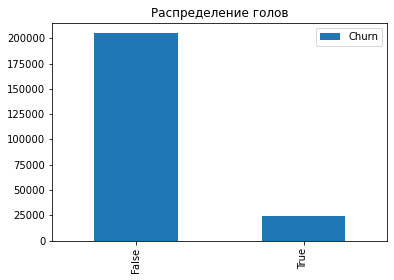

In [8]:
shots["is_goal"].value_counts().plot(kind="bar", label="Churn")
plt.legend()
plt.title("Распределение голов");
print("Общее количество ударо -", len(shots["is_goal"]))

Имеем на **229135** удара всего **24441** гола

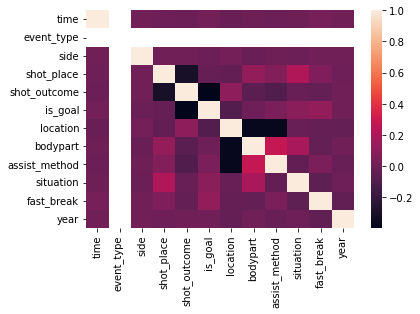

In [9]:
corr_matrix = shots.drop(
    ["id_odsp", "id_event", "sort_order", "text","event_type2"], axis=1
).corr()
sns.heatmap(corr_matrix);

Давайте посмотрим, как распределяются различные возможные результаты выстрела.

In [10]:
pie = shots[['shot_outcome', 'id_event']].groupby('shot_outcome').count().reset_index().rename(columns={'id_event': 'count'})

In [11]:
pie.shot_outcome = pie.shot_outcome.astype(int)
pie.shot_outcome = pie.shot_outcome.replace({1: 'On Target', 2: 'Off Target', 3: 'Blocked', 4: 'Hit the Bar'})

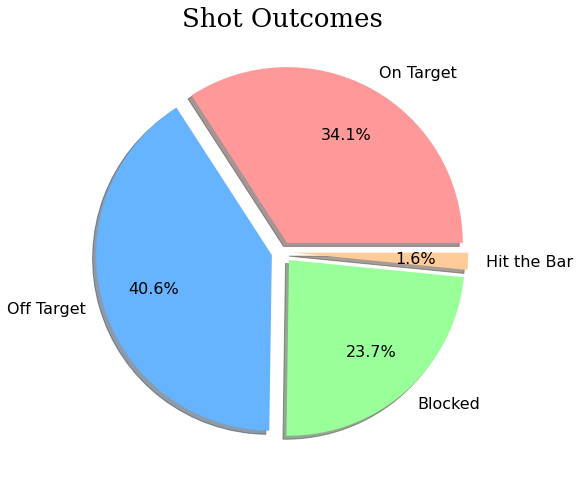

In [12]:
fig, ax = plt.subplots(figsize=[8,8])
labels = pie['shot_outcome']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.pie(x=pie['count'], autopct="%.1f%%", labels=labels, explode=[0.06]*4, pctdistance=0.7, colors=colors, shadow=True, \
       textprops=dict(fontsize=16))
plt.title("Shot Outcomes", fontsize=26, fontfamily='serif')
plt.tight_layout()
plt.show()

Мы видим, что большинство ударов не в цель, но разница с попаданием в цель не так велика. Конечно, только небольшая часть этих ударов по воротам заканчивается голами, потому что вратарь пытается предотвратить голы с другой стороны.

Теперь давайте посмотрим, куда чаще всего наносят удары игроки.

In [13]:
bar = shots[['shot_place', 'id_event']].groupby('shot_place').count().reset_index().rename(columns={'id_event': 'count'})
bar.shot_place = bar.shot_place.astype(int)
bar.shot_place = bar.shot_place.replace({1: 'Bit too high', 2: 'Blocked', 3: 'Bottom left corner', 4: 'Bottom right corner', \
                                        5: 'Centre of the goal', 6: 'High and wide', 7: 'Hits the bar', 8: 'Misses to the left', \
                                        9: 'Misses to the right', 10: 'Too high', 11: 'Top centre of the goal', \
                                        12: 'Top left corner', 13: 'Top right corner'})

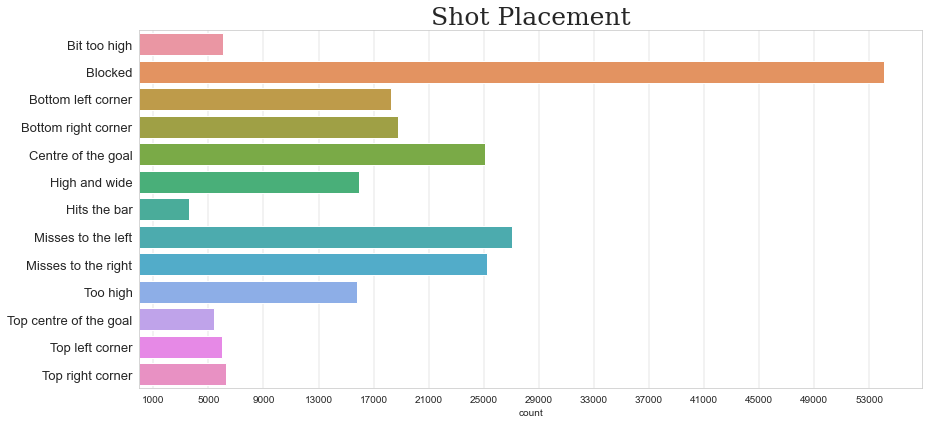

In [14]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=[13,6])
labels = bar['shot_place']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
ax = sns.barplot(x=bar['count'], y=labels)
ax.set_yticklabels(labels, size = 13)
ax.set_xticks(np.arange(1000,57000,4000))
ax.set_ylabel(ylabel='')
plt.title("Shot Placement", fontsize=25, fontfamily='serif')
plt.tight_layout()
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

Мы видим, что большинство ударов заблокированы противниками, но это потому, что все незаблокированные удары сгруппированы во множество различных категорий. На предыдущей круговой диаграмме мы видели, что на самом деле 24% бросков действительно заблокированы, что все еще является довольно высоким процентом.
По незаблокированным ударам мы видим, что большинство либо направлены в центр ворот, либо промахиваются в левую или правую сторону.
Теперь мы исследуем то, что будет очень важно для нашей модели xG: какой процент бросков заканчивается голами. Мы разделим этот анализ на разные лиги и по годам, чтобы проверить, есть ли различия в закономерностях в разных частях мира или в разные годы.

In [15]:
goals  = shots[['is_goal', 'id_event', 'country']].groupby(['is_goal', 'country']).count().reset_index().rename(columns={'id_event': 'count'})
goals.is_goal = goals.is_goal.replace({1: 'Goal', 0: 'No Goal'})
goals

,is_goal,country,count
0,False,England,30360
1,False,France,43795
2,False,Germany,36916
3,False,Italy,49253
4,False,Spain,44370
5,True,England,3552
6,True,France,5199
7,True,Germany,4621
8,True,Italy,5491
9,True,Spain,5578


In [16]:
goals['percentage']=0
for i in range(len(goals)):
    for country in goals.country.unique():
        if goals.iloc[i,goals.columns.get_loc("country")]==country:
            goals.iloc[i,goals.columns.get_loc("percentage")]=goals.iloc[i,goals.columns.get_loc("count")] / \
                                                            goals[goals.country==country]['count'].sum()
goals['percentage']=round(goals['percentage']*100,2)
goals

,is_goal,country,count,percentage
0,False,England,30360,89.53
1,False,France,43795,89.39
2,False,Germany,36916,88.87
3,False,Italy,49253,89.97
4,False,Spain,44370,88.83
5,True,England,3552,10.47
6,True,France,5199,10.61
7,True,Germany,4621,11.13
8,True,Italy,5491,10.03
9,True,Spain,5578,11.17


In [17]:
# функция для настройки одного графика
def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}%'.format(p.get_height())
            ax.text(_x, _y+2, value, ha="center", fontsize=14)
# функция для настройки множества графиков
def show_values_on_bars(axs):
    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

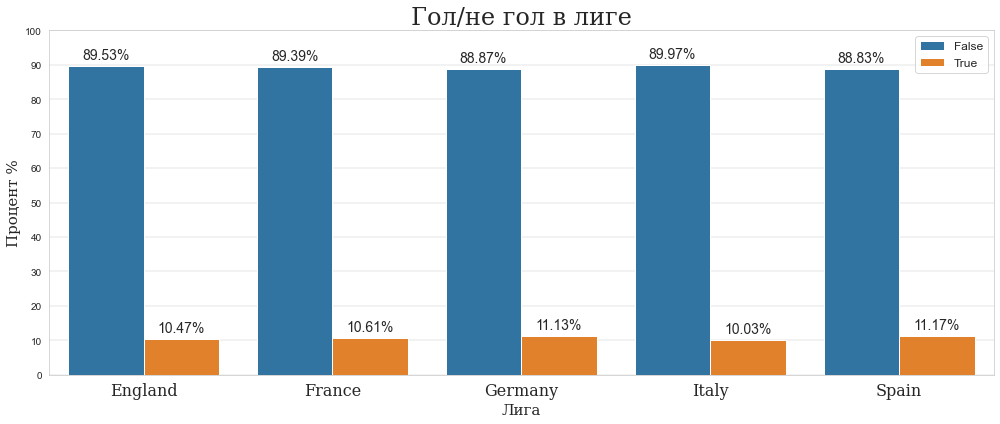

In [18]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=[14,6])
colors = ['#ff9999','#66b3ff']
ax = sns.barplot(data=goals, y='percentage', hue='is_goal', x='country')
ax.set_yticks(np.arange(0,110,10))
ax.set_ylabel(ylabel='Процент %', fontsize=15, fontfamily='serif')
ax.set_xlabel(xlabel='Лига', fontsize=15, fontfamily='serif')
ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=16, fontfamily='serif')
plt.title("Гол/не гол в лиге", fontsize=24, fontfamily='serif')
plt.tight_layout()
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='y')
plt.legend(fontsize=12)
show_values_on_bars(ax)
plt.show()

В разных основных лигах практически нет различий. Кажется, что любой данный удар имеет 10-11% шансов стать голом в любой точке мира.

In [19]:
goals = shots[['is_goal', 'id_event', 'year']].groupby(['is_goal', 'year']).count().reset_index().rename(columns={'id_event': 'count'})
goals.is_goal = goals.is_goal.replace({1: 'Goal', 0: 'No Goal'})
goals

,is_goal,year,count
0,False,2011,14549
1,False,2012,32526
2,False,2013,35019
3,False,2014,39964
4,False,2015,41000
5,False,2016,38953
6,False,2017,2683
7,True,2011,1656
8,True,2012,3909
9,True,2013,4212


In [20]:
goals['percentage']=0
for i in range(len(goals)):
    for year in goals.year.unique():
        if goals.iloc[i,goals.columns.get_loc("year")]==year:
            goals.iloc[i,goals.columns.get_loc("percentage")]=goals.iloc[i,goals.columns.get_loc("count")] / \
                                                            goals[goals.year==year]['count'].sum()
goals['percentage']=round(goals['percentage']*100,2)
goals

,is_goal,year,count,percentage
0,False,2011,14549,89.78
1,False,2012,32526,89.27
2,False,2013,35019,89.26
3,False,2014,39964,89.51
4,False,2015,41000,89.54
5,False,2016,38953,88.86
6,False,2017,2683,89.73
7,True,2011,1656,10.22
8,True,2012,3909,10.73
9,True,2013,4212,10.74


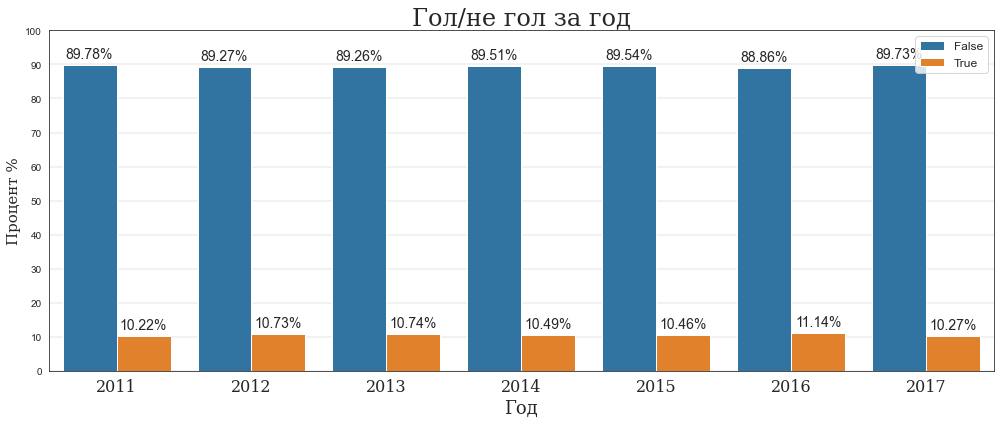

In [21]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=[14,6])
colors = ['#ff9999','#66b3ff']
ax = sns.barplot(data=goals, y='percentage', hue='is_goal', x='year')
ax.set_yticks(np.arange(0,110,10))
ax.set_ylabel(ylabel='Процент %', fontsize=15, fontfamily='serif')
ax.set_xlabel(xlabel='Год', fontsize=18, fontfamily='serif')
ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=16, fontfamily='serif')
plt.title("Гол/не гол за год", fontsize=24, fontfamily='serif')
plt.tight_layout()
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='y')
plt.legend(fontsize=12)
show_values_on_bars(ax)
plt.show()

Опять же, мы обнаруживаем, что соотношение забитых/не забитых голов почти одинаково во времени.
Так что становится совершенно ясно, что статистически говоря, 1 из 9-10 бросков являются голами, независимо от того, где и когда вы смотрите.

## 4. Генерация и селекция признаков, нормализация + выбор метода/алгоритма, модели, архитектуры (для НС)

Здесь мы подготавливаем данные, чтобы сделать их пригодными в качестве входных данных для нашей модели xG. Сначала я немного расскажу о том, что такое ожидаемые цели.

**Модели ожидаемого гола** — это попытка количественно оценить вероятность того, что определенный удар приведет к голу. С помощью этой метрики мы можем проанализировать, что произошло в игре, кроме того, сколько голов забила каждая команда. Так как игра выигрывается голами, а голы забиваются только ударами (за исключением редкого случая автогола), то для построения метрики xG нужны только данные бросков. Другими словами, все остальное, что может повлиять на то, сколько «ожидаемых голов» забьет команда, должно происходить в первую очередь за счет большего количества бросков. Например, можно утверждать, что если команда B получает 3 красные карточки, то предполагается, что команда A забьет больше голов (увеличение ожидаемого количества голов). Однако на самом деле наличие еще 3 игроков на поле приведет к большему количеству (и, возможно, лучшему) бросков, а увеличение количества ударов приведет к увеличению ожидаемого количества голов. Поэтому **удары и их информация** - единственное, что нам нужно учитывать

Давайте подготовим наборы X и Y. Y просто включит каждый удар в базу данных и будет ли это гол или нет. Это наша целевая переменная. X будет включать всю необходимую информацию о нем, которая есть в наших данных. Рассмотрим необходимые нам поля:


- *location*: нападающая половина, оборонительная половина, центр штрафной, левый фланг, правый фланг, сложный угол и дальняя дистанция, сложный угол слева, сложный угол справа, левая сторона штрафной площади, левая сторона шестиметровой штрафной площади , правая сторона штрафной площади, правая сторона шестиметровой площадки, очень близко, одиннадцатиметровая отметка, вне штрафной площади, дальняя дистанция, более 35 ярдов, более 40 ярдов, не записано.

- *bodypart*: правая ступня, левая ступня, голова.пеф

- *assist_method* : нет, пас, кросс, пас головой, через мяч.

- *situation*: открытая игра, стандарт, угловой, свободный удар.

- *fast_break*: 1 или 0, вне зависимости от того, был ли удар с быстрого отрыва или нет.

Таким образом, у нас есть много значимой информации о каждом кадре. Место, откуда был сделан выстрел, какая часть тела использовалась для удара, как был сделан удара (после передачи, прострела и т. д.), а также ситуация или контекст, в котором произошел удар (проход в штрафную, угловой и др.)

Поскольку все это категориальные переменные, мы должны преобразовать их в бинарные фиктивные переменные (за исключением fast_break, которая уже является бинарной).

In [22]:
data = pd.get_dummies(shots.iloc[:,-8:-3], columns=['location', 'bodypart','assist_method', 'situation'])
data.columns = ['fast_break', 'loc_centre_box', 'loc_diff_angle_lr', 'diff_angle_left', 'diff_angle_right',
                'left_side_box', 'left_side_6ybox', 'right_side_box', 'right_side_6ybox', 'close_range',
                'penalty', 'outside_box', 'long_range', 'more_35y', 'more_40y', 'not_recorded', 'right_foot', 
                'left_foot', 'header', 'no_assist', 'assist_pass', 'assist_cross', 'assist_header',
                'assist_through_ball', 'open_play', 'set_piece', 'corner', 'free_kick']
data['is_goal'] = shots['is_goal']
print(len(data))
print(data.is_goal.sum())
print(len(data.columns)-1)

229135
24441
28


Итак, у нас всего 229 135 ударов, из которых 24 441 гол. Для каждого выстрела у нас есть 28 различных характеристик, которые его описывают. Все эти 28 характеристик являются бинарными.

Теперь мы разделим наши X и y на два разных набора для обучения и тестирования. Я буду использовать 65% из них для обучения нашей модели и 35% для ее тестирования. Это потому, что у нас достаточно точек данных, поэтому 65% должно быть достаточно для правильного обучения, и я бы предпочел оставить как можно больше данных для чистого тестирования позже.

## 5. Генерация наборов для обучения, тестирования и валидации

In [23]:
X = data.iloc[:,:-1] # data без is_goal
y = data.iloc[:,-1] # data только с is_goal
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=1)

## 6. Настройка гиперпараметров (для НС), выбор параметров метода/алгоритма

Сначала мы обучим классификатор повышения градиента, который является очень мощным алгоритмом. Он состоит из деревьев решений. Поскольку эти деревья, как правило, подходят для обучающих данных, разработка тысяч различных деревьев с использованием разных предикторов и выборок каждый раз помогает нам уменьшить дисперсию наших прогнозов в рамках дисперсии.

Мы используем hyperopt, чтобы узнать лучшие гиперпараметры для настройки нашей модели. Он пробует разные настройки во всех диапазонах, которые мы ему даем, а затем придерживается наиболее перспективных.

In [90]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

def evaluate_model(params): 
    modelGradient = GradientBoostingClassifier(
                        learning_rate=params['learning_rate'],
                        min_samples_leaf=params['min_samples_leaf'],
                        max_depth = params['max_depth'],
                        max_features = params['max_features']
                        )

    modelGradient.fit(X_train, y_train)
    return {
        'learning_rate': params['learning_rate'],
        'min_samples_leaf': params['min_samples_leaf'],
        'max_depth': params['max_depth'],
        'max_features': params['max_features'],
        'train_ROCAUC': roc_auc_score(y_train, modelGradient.predict_proba(X_train)[:, 1]),
        'test_ROCAUC': roc_auc_score(y_test, modelGradient.predict_proba(X_test)[:, 1]),
        'recall': recall_score(y_test, modelGradient.predict(X_test)),
        'precision': precision_score(y_test, modelGradient.predict(X_test)),
        'f1_score': f1_score(y_test, modelGradient.predict(X_test)),
        'train_accuracy': modelGradient.score(X_train, y_train),
        'test_accuracy': modelGradient.score(X_test, y_test),
    }

def objective(params):
    res = evaluate_model(params)
    
    res['loss'] = - res['test_ROCAUC'] # hyperopt минимизирует потерю
    res['status'] = STATUS_OK # здесь мы говорим hyperopt что эксперимент прошел успешно
    return res 

hyperparameter_space = {
        'learning_rate': hp.uniform('learning_rate', 0.05, 0.3),
        'min_samples_leaf': hp.choice('min_samples_leaf', range(15, 200)),
        'max_depth': hp.choice('max_depth', range(2, 20)),
        'max_features': hp.choice('max_features', range(3, 27))
}

In [25]:
trials = Trials()
fmin(
    objective,
    space=hyperparameter_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials
);

100%|████████| 50/50 [08:22<00:00, 10.05s/trial, best loss: -0.8195571024769979]


In [26]:
pd.DataFrame(trials.results).sort_values(by='f1_score', ascending=False).head(5)

,learning_rate,min_samples_leaf,max_depth,max_features,train_ROCAUC,test_ROCAUC,recall,precision,f1_score,train_accuracy,test_accuracy,loss,status
32,0.102101,31,16,9,0.818948,0.818475,0.268462,0.711880,0.389890,0.910546,0.910908,-0.818475,ok
14,0.233904,82,14,24,0.818986,0.818551,0.268109,0.711833,0.389511,0.910566,0.910883,-0.818551,ok
45,0.209452,80,13,19,0.818910,0.818589,0.267756,0.712899,0.389297,0.910539,0.910920,-0.818589,ok
29,0.095423,158,7,14,0.817526,0.819557,0.267168,0.716719,0.389241,0.910405,0.911095,-0.819557,ok
4,0.272223,78,13,11,0.818947,0.818478,0.267756,0.712453,0.389231,0.910533,0.910896,-0.818478,ok


Мы получаем наилучшие результаты с указанными выше гиперпараметрами, хотя видим, что при использовании разных значений параметров нет очень больших различий. Приятно видеть, что нет никаких признаков переобучения, поскольку наши прогнозы одинаково хороши как для обучения, так и для тестирования примеров.

**Gradient Boosting Classifier**

In [27]:
modelGradient = GradientBoostingClassifier(
                        learning_rate=0.285508,
                        min_samples_leaf=99,
                        max_depth = 19,
                        max_features = 7
                        )
modelGradient.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.285508, max_depth=19, max_features=7,
                           min_samples_leaf=99)

**Logistic Regression**

In [28]:
modelLogistic = LogisticRegression(max_iter=400)
modelLogistic.fit(X_train, y_train)

LogisticRegression(max_iter=400)

## 7. Выбор метрики оценки качества

Давайте более подробно проанализируем производительности моделей

- *modelGradient*

In [29]:
print('Тестовый набор содержит {} выстрелов, из которых {} голов.'.format(len(y_test), y_test.sum()))
print('Точность определения того, является ли удар голом или нет, составляет {}%.'.format(round(modelGradient.score(X_test, y_test)*100), 0))
print('Наш классификатор получает ROC-AUC {}%'.format(round(roc_auc_score(y_test, modelGradient.predict_proba(X_test)[:, 1])*100),0))


Тестовый набор содержит 80198 выстрелов, из которых 8504 голов.
Точность определения того, является ли удар голом или нет, составляет 91%.
Наш классификатор получает ROC-AUC 82%


Итак, мы видим, что наша модель способна правильно предсказать, является ли удар голом или нет, в 91% случаев. Кроме того, мы получаем довольно хорошую метрику ROC-AUC 82%. Это выглядит очень многообещающе.

Однако эти две метрики не учитывают, что наш набор данных сильно несбалансирован. Есть гораздо больше бросков, которые не становятся голами, чем бросков, которые достигают цели. Так, например, если бы мы просто предсказывали, что бросок не будет забит каждый раз, мы бы уже получили точность 89%.

Поэтому нам нужны другие показатели, чтобы действительно понять, хороша ли наша модель.


Теперь мы рассмотрим PR-AUC (Precision-Recall Under the Curve) и статистику Каппа Коэна. Они больше подходят для нашего случая, поскольку они учитывают дисбаланс в наших данных.

In [30]:
print('Базовая производительность для PR-AUC составляет {}%. Это PR-AUC, которое мы получили бы путем случайного угадывания.'.format(round(y_train.mean(),2)))
print('Наша модель получает PR-AUC {}%.'.format(round(average_precision_score(y_test, modelGradient.predict_proba(X_test)[:, 1])*100,2)))
print('Наш классификатор получает коэффициент Каппы Коэна {}.'.format(round(cohen_kappa_score(y_test,modelGradient.predict(X_test)),2)))



Базовая производительность для PR-AUC составляет 0.11%. Это PR-AUC, которое мы получили бы путем случайного угадывания.
Наша модель получает PR-AUC 47.36%.
Наш классификатор получает коэффициент Каппы Коэна 0.35.


Мы заканчиваем оценку модели матрицей ошибок и дополнительным статистическим отчетом.

In [31]:
print('Матрица ошибок:\n')
print(confusion_matrix(y_test,modelGradient.predict(X_test)))
print('\n Отчет:')
print(classification_report(y_test,modelGradient.predict(X_test)))

Матрица ошибок:

[[70783   911]
 [ 6236  2268]]

 Отчет:
              precision    recall  f1-score   support

       False       0.92      0.99      0.95     71694
        True       0.71      0.27      0.39      8504

    accuracy                           0.91     80198
   macro avg       0.82      0.63      0.67     80198
weighted avg       0.90      0.91      0.89     80198



Матрица ошибок суммирует все прогнозы. Это говорит нам о том, что из всех ударов, которые не были голами, наша модель правильно определила 70 781 как незабитые и допустила ошибку в 6 238 случаях, когда она предсказывала, что удар не будет голом, но он был. Из другого столбца мы видим, что он правильно предсказал 913 голов, но не смог предсказать 2266 успешных ударов в качестве голов.

Из отчета видно, что модель имеет отличные показатели, когда речь идет о прогнозировании класса False (отсутствие гола), но не так хороша для прогнозирования класса True (гола). С последним у нас есть точность 71% и полнота 27%, в результате чего оценка F1 равна 0,39. Это приличные цифры, но не очень хорошие. 

- *modelLogistic*

In [32]:
print('Тестовый набор содержит {} выстрелов, из которых {} голов.'.format(len(y_test), y_test.sum()))
print('Точность определения того, является ли удар голом или нет, составляет {}%.'.format(round(modelLogistic.score(X_test, y_test)*100), 0))
print('Наш классификатор получает ROC-AUC {}%'.format(round(roc_auc_score(y_test, modelLogistic.predict_proba(X_test)[:, 1])*100),0))


Тестовый набор содержит 80198 выстрелов, из которых 8504 голов.
Точность определения того, является ли удар голом или нет, составляет 91%.
Наш классификатор получает ROC-AUC 82%


In [33]:
print('Базовая производительность для PR-AUC составляет {}%. Это PR-AUC, которое мы получили бы путем случайного угадывания.'.format(round(y_train.mean(),2)))
print('Наша модель получает PR-AUC {}%.'.format(round(average_precision_score(y_test, modelLogistic.predict_proba(X_test)[:, 1])*100,2)))
print('Наш классификатор получает коэффициент Каппы Коэна {}.'.format(round(cohen_kappa_score(y_test,modelLogistic.predict(X_test)),2)))



Базовая производительность для PR-AUC составляет 0.11%. Это PR-AUC, которое мы получили бы путем случайного угадывания.
Наша модель получает PR-AUC 47.08%.
Наш классификатор получает коэффициент Каппы Коэна 0.35.


In [34]:
print('Матрица ошибок:\n')
print(confusion_matrix(y_test,modelLogistic.predict(X_test)))
print('\n Отчет:')
print(classification_report(y_test,modelLogistic.predict(X_test)))

Матрица ошибок:

[[70820   874]
 [ 6265  2239]]

 Отчет:
              precision    recall  f1-score   support

       False       0.92      0.99      0.95     71694
        True       0.72      0.26      0.39      8504

    accuracy                           0.91     80198
   macro avg       0.82      0.63      0.67     80198
weighted avg       0.90      0.91      0.89     80198



Мы получаем почти те же результаты, что и с Gradient Boosting. В этом случае обычно следует предпочесть более простую модель, в данном случае логистическую регрессию. Однако есть 33 гола, которые были правильно распознаны градиентным бустингом, но не были захвачены логистической регрессией. Несмотря на то, что это не большая разница, я выберу Gradient Boosting именно из-за этого.

Давайте посмотрим, какие из наших параметров более важны для нашей модели, чтобы принять решение о том, является ли каждый удар голом или нет.

In [98]:
# Функция возвращает важность столбцов в датасэте, чем выше важность, тем лучше. 
def plot_feature_importances(df):
    df = df.sort_values('importance', ascending = False).reset_index()
    # Нормализуем важность свойств, чтобы в сумме получить единицу
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    # Горизонтальная гистограмма важности
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    # Сортировка объектов по важности
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    # Установим метки
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    plt.xlabel('Важность'); plt.title('Важность параметров')
    plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Классификатор случайного леса
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 12, verbose = 1, n_jobs = -1)
random_forest.fit(X_train, y_train)
features = list(X.columns)
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

feature_importances_sorted = plot_feature_importances(feature_importances)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Есть одна вещь, о которой следует беспокоиться, это высокий коэффициент location=not_recorded. По-видимому, есть удары, место которых не зафиксировано, и по какой-то причине эти выстрелы с большой долей вероятности являются голами. Это упрощает работу модели. Чтобы лучше понять модель, было бы интересно удалить эти строки и проверить ее производительность. Я попробовал это, и это приводит к небольшому снижению производительности (ROC-AUC = 81%, PR-AUC = 41%), поэтому нет слишком больших различий. Я все равно оставлю эти строки, так как анализы игроков буду делать позже и не хочу стирать ценную информацию о голах игроков.

## 8. Развертывание и работа модели, визуализация результатов

Мы начнем с добавления имеющейся у нас информации об ожидаемых голах к каждому удару в наших исходных данных. Оттуда мы можем извлечь множество интересных метрик об игроках, причем все эти метрики так или иначе связаны с новыми прогнозами модели xG для каждого удара.

In [38]:
shots['prediction'] = modelGradient.predict_proba(X)[:, 1]
shots['difference'] = shots['prediction'] - shots['is_goal']

Какие игроки являются лучшими финишерами?
Глядя на разницу между количеством голов игрока и его ожидаемым количеством голов, мы можем увидеть, кто больше забивает. Мы можем подойти к этой проблеме с двух разных точек зрения:

- Посмотрим на разницу между общим количеством забитых голов и общим количеством ожидаемых голов: это покажет нам, какой игрок забил наибольшее количество голов по сравнению с тем, что он должен был забить.

- Посмотрим на соотношение между общим количеством забитых голов и общим количеством ожидаемых голов: это покажет нам точное соотношение того, сколько голов игрок на самом деле забивает на каждый гол, который он должен был забить.

In [39]:
players = shots.groupby('player').sum().reset_index()
players.rename(columns={'is_goal': 'trueGoals', 'prediction': 'expectedGoals'}, inplace=True)
players.expectedGoals = round(players.expectedGoals,2)
players.difference = round(players.difference,2)
players['ratio'] = players['trueGoals'] / players['expectedGoals']
print(round(players.expectedGoals.corr(players.trueGoals),3))

0.977


Как было сказано выше, мы видим, что корреляция между trueGoals и ожидаемыми голами очень высока, что хорошо говорит о нашей модели xG.

In [51]:
show = players.sort_values(['difference', 'trueGoals']).reset_index(drop=True)
show['rank'] = show.index+1
show = show[['rank', 'player', 'difference', 'trueGoals', 'expectedGoals']].head(10)
show.head(5)

,rank,player,difference,trueGoals,expectedGoals
0,1,Lionel Messi,-58.63,205,146.37
1,2,Zlatan Ibrahimovic,-33.83,153,119.17
2,3,Cristiano Ronaldo,-32.34,198,165.66
3,4,Luis Suarez,-31.75,96,64.25
4,5,Gonzalo Higuain,-31.64,118,86.36


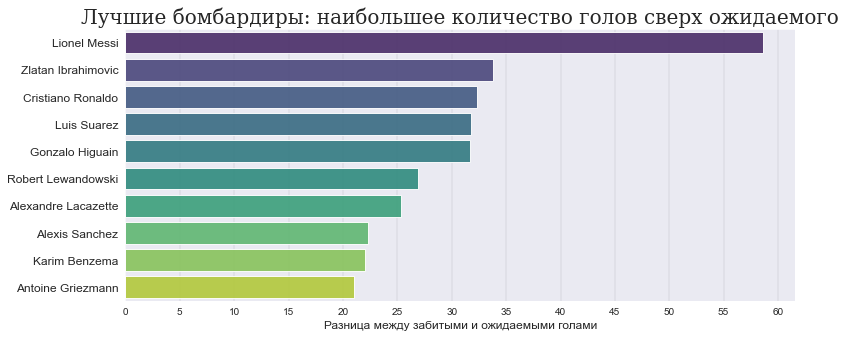

In [52]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[12,5])
ax = sns.barplot(x=abs(show['difference']), y=show['player'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,65,5))
ax.set_xlabel(xlabel='Разница между забитыми и ожидаемыми голами', fontsize=12)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Лучшие бомбардиры: наибольшее количество голов сверх ожидаемого", fontsize=20, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, alpha=0.8, axis='x')
plt.show()

Неудивительно, что мы видим, что Месси намного лучше всех остальных по этому показателю. Судя по количеству и характеристикам всех бросков, он должен был забить 146 голов, но вместо этого он забил 205 голов. Как и ожидалось, в верхней части списка мы находим известных игроков мирового уровня.

Давайте посмотрим, что произойдет, если вместо этого мы посмотрим на соотношение забитых/ожидаемых голов. Мы оставим только игроков, забивших в общей сложности более 30 голов

In [53]:
show = players[players['trueGoals']>30].sort_values(['ratio', 'trueGoals'], ascending=False).reset_index(drop=True)
show['rank'] = show.index+1
show = show[['rank', 'player', 'ratio', 'trueGoals', 'expectedGoals']].head(10)
show.head(5)

,rank,player,ratio,trueGoals,expectedGoals
0,1,Franck Ribery,1.906578,40,20.98
1,2,Mario Gotze,1.585941,37,23.33
2,3,Bas Dost,1.549720,36,23.23
3,4,Heungmin Son,1.519468,32,21.06
4,5,Luis Suarez,1.494163,96,64.25


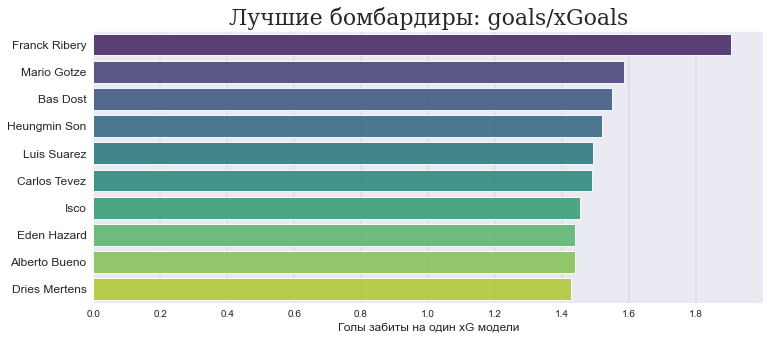

In [54]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[12,5])
ax = sns.barplot(x=show['ratio'], y=show['player'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,1.9,0.2))
ax.set_xlabel(xlabel='Голы забиты на один xG модели', fontsize=12)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Лучшие бомбардиры: goals/xGoals", fontsize=22, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

Мы находим Рибери самым результативным бомбардиром в игре. Одна приятная особенность этой метрики заключается в том, что ее очень легко интерпретировать. В случае с Рибери из каждого гола, который он должен был забить в зависимости от количества и контекста его ударов, он забил почти два.

**Лучшие бомбардиры за год в лиге**


In [55]:
players_per_year = shots.groupby(['year', 'country', 'player']).sum().reset_index()
players_per_year.rename(columns={'is_goal': 'trueGoals', 'prediction': 'expectedGoals'}, inplace=True)
players_per_year.expectedGoals = round(players_per_year.expectedGoals,2)
players_per_year.difference = round(players_per_year.difference,2)
players_per_year['ratio'] = players_per_year['trueGoals'] / players_per_year['expectedGoals']
players_per_year['ratio'] = round(players_per_year.ratio, 2)

In [56]:
def best_finishers_per_year(years, leagues, min_goals, df):
    years_res=[]; leagues_res=[]; players_res=[]; ratio_res=[]; goals=[]
    players_per_year = df[df['trueGoals']>min_goals]
    for league in leagues:
        for year in years:
            results = players_per_year[(players_per_year['year']==year) & (players_per_year['country']==league)].sort_values(by='ratio', ascending=False).reset_index(drop=True)
            results['rank'] = results.index + 1
            if len(results)>0:
                years_res.append(year)
                leagues_res.append(league)
                players_res.append(results[results['rank']==1]['player'].iloc[0])
                ratio_res.append(results[results['rank']==1]['ratio'].iloc[0])
                goals.append(results[results['rank']==1]['trueGoals'].iloc[0])
    return years_res, leagues_res, players_res, ratio_res, goals

In [57]:
years, leagues, players_res, ratio, goals = best_finishers_per_year(years = players_per_year.year.unique(), leagues=players_per_year.country.unique(),\
                       min_goals=12, df=players_per_year)
results_perYear = pd.DataFrame()
results_perYear['League']=leagues
results_perYear['Year']=years
results_perYear['bestFinisher']=players_res
results_perYear['Goals']=goals
results_perYear['Goals/xGoals Ratio']=ratio
results_perYear

,League,Year,bestFinisher,Goals,Goals/xGoals Ratio
0,France,2011,Olivier Giroud,13,1.25
1,France,2012,Zlatan Ibrahimovic,18,1.47
2,France,2013,Dario Cvitanich,16,1.70
3,France,2014,Cheick Diabate,13,1.61
4,France,2015,Benjamin Moukandjo,13,1.69
5,France,2016,Zlatan Ibrahimovic,21,2.27
6,Germany,2011,Klaasjan Huntelaar,15,1.81
7,Germany,2012,Martin Harnik,15,1.79
8,Germany,2013,Ivica Olic,13,2.23
9,Germany,2014,Josip Drmic,14,2.03


**Худшие бомбардиры**

In [62]:
show = players.sort_values(['difference', 'trueGoals']).reset_index(drop=True)
show['rank'] = show.index+1
show = show[['rank', 'player', 'difference', 'trueGoals', 'expectedGoals']].tail(10)
show.tail(3)

,rank,player,difference,trueGoals,expectedGoals
4777,4778,Riccardo Meggiorini,7.91,15,22.91
4778,4779,Diego Godin,7.92,12,19.92
4779,4780,Roberto Trashorras,7.96,6,13.96


In [63]:
show = players[players['trueGoals']>30].sort_values(['ratio', 'trueGoals'], ascending=False).reset_index(drop=True)
show['rank'] = show.index+1
show = show.sort_values(by='rank', ascending=False)
show = show[['rank', 'player', 'ratio', 'trueGoals', 'expectedGoals']].head(10)
show.head(3)

,rank,player,ratio,trueGoals,expectedGoals
140,141,Giampaolo Pazzini,0.781447,31,39.67
139,140,Mario Balotelli,0.812091,36,44.33
138,139,Gonzalo Bergessio,0.843767,31,36.74


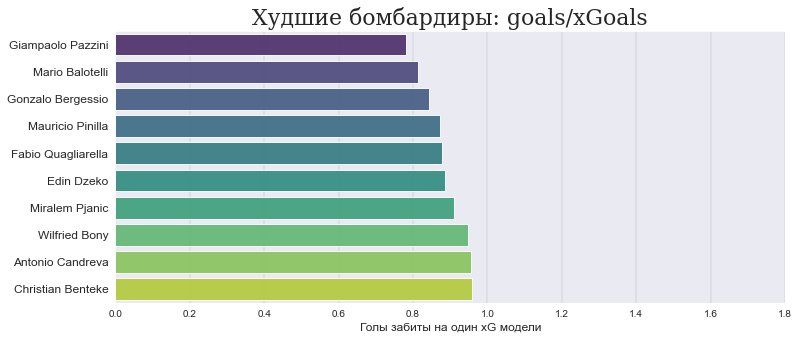

In [66]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[12,5])
ax = sns.barplot(x=show['ratio'], y=show['player'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,1.9,0.2))
ax.set_xlabel(xlabel='Голы забиты на один xG модели', fontsize=12)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Худшие бомбардиры: goals/xGoals", fontsize=22, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

Среди прочих мы находим таких игроков, как Марио Балотелли, Джампаоло Паццини или Эдин Джеко, которые забили намного меньше голов, чем должны были. Джампаоло Паццини фактически находится в обоих списках (общая абсолютная разница в голах и соотношение trueGoals/xGoals).

Интересно посмотреть на игроков, забивших гораздо меньше голов, чем ожидалось. Это как бы говорит нам о том, что эти игроки упустили слишком много моментов и должны улучшить свою стрельбу. Но это также означает, что они создавали намного больше голевых моментов, чем то, о чем говорит нам самая распространенная статистика (например, голы). Так что в этом смысле они недооценены.

**Какие игроки делают лучшие/самые опасные передачи?**

Глядя на игрока, совершившего передачу перед ударом, мы можем оценить, сколько xG игрок создал за счет своей передачи.

In [68]:
passing = shots[shots.assist_method.isin([1,4])]
passing_players = passing.groupby('player2').sum().reset_index()
passing_players.rename(columns={'player2': 'player', 'event_type': 'n_passes', 'is_goal': 'trueGoals_created', 'prediction': 'expectedGoals_created'}, inplace=True)
show = passing_players.sort_values('expectedGoals_created', ascending=False).reset_index(drop=True)
show['rank'] = show.index+1
show[['rank', 'player', 'n_passes', 'trueGoals_created', 'expectedGoals_created']].head(5)

,rank,player,n_passes,trueGoals_created,expectedGoals_created
0,1,Lionel Messi,350,68,51.293988
1,2,Mesut Ozil,343,35,36.678917
2,3,Zlatan Ibrahimovic,270,36,36.201551
3,4,Cesc Fabregas,264,53,36.171798
4,5,Marek Hamsik,370,50,34.972683


Это становится немного скучно, но мы снова видим Месси на вершине. В этом случае он является игроком, который создал наиболее ожидаемые голы для своих товарищей по команде за 7 лет наших данных.

Теперь мы можем вместо этого посмотреть на среднее значение xG этих передач, чтобы увидеть, кто из игроков пытается выполнить наиболее опасный пас.

In [69]:
show['xG_perpass'] = show['expectedGoals_created'] / show['n_passes']
show = show[show['n_passes']>80].sort_values('xG_perpass', ascending=False).reset_index(drop=True)
show['rank'] = show.index+1
show = show[['rank', 'player', 'n_passes', 'xG_perpass']].head(10)
show.head(5)

,rank,player,n_passes,xG_perpass
0,1,Luis Suarez,185,0.164791
1,2,Gareth Bale,109,0.156703
2,3,Angel Di Maria,211,0.150858
3,4,Raul Garcia,90,0.149844
4,5,Lionel Messi,350,0.146554


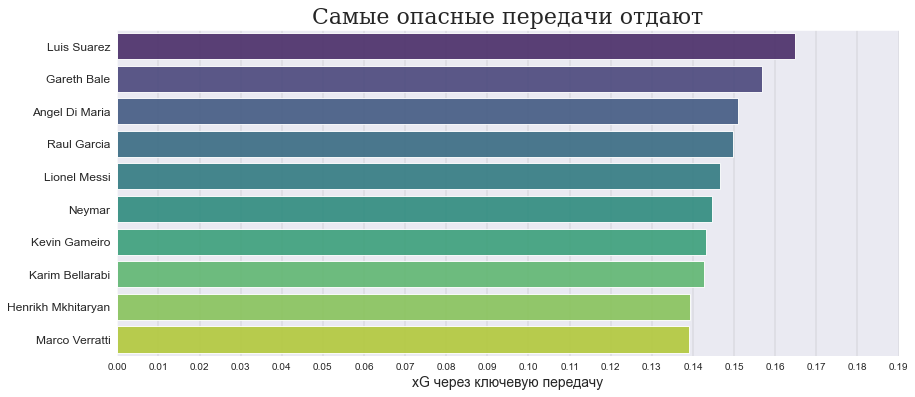

In [71]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[14,6])
ax = sns.barplot(x=show['xG_perpass'], y=show['player'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,0.2,0.01))
ax.set_xlabel(xlabel='xG через ключевую передачу', fontsize=14)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Самые опасные передачи отдают", fontsize=22, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

Мы можем видеть Луиса Суареса, Ди Марию и Гарета Бэйла среди игроков, которые в среднем делают самые опасные передачи, измеряемые ожидаемой ценностью голов при последующем ударе.

**Каким игрокам больше всего не везет при передаче мяча?**

Мы также можем увидеть, кому больше всего не везет в пасах. Т.е., у кого наибольшая разница между ожидаемым количеством голов в результате их пасов и количеством голов, забитых ими на самом деле. Я говорю «не повезло», потому что, в отличие от игрока, который делает бросок, этот другой игрок не несет ответственности за то, смогли ли его партнеры по команде забить после его отличной передачи или нет!

In [77]:
passing = shots[shots.assist_method.isin([1,4])]
passing_players = passing.groupby('player2').sum().reset_index()
passing_players.rename(columns={'player2': 'player', 'event_type': 'n_passes', 'is_goal': 'trueGoals_created', 'prediction': 'expectedGoals_created'}, inplace=True)
show = passing_players[passing_players['n_passes']>50].sort_values('difference', ascending=False).reset_index(drop=True)
show['rank'] = show.index+1
show[['rank', 'player', 'n_passes', 'trueGoals_created', 'expectedGoals_created', 'difference']].head(20)

,rank,player,n_passes,trueGoals_created,expectedGoals_created,difference
0,1,Joan Verdu,134,7,14.585246,7.585246
1,2,Xabi Prieto,152,6,13.303372,7.303372
2,3,Philippe Coutinho,177,13,19.941539,6.941539
3,4,Luca Cigarini,164,6,12.919044,6.919044
4,5,Alejandro Gomez,137,5,11.717980,6.717980
5,6,Antonio Di Natale,136,7,13.189828,6.189828
6,7,Victor Ibarbo,116,6,12.116226,6.116226
7,8,Nolito,179,18,23.884351,5.884351
8,9,Mariano,100,2,7.779896,5.779896
9,10,Ever Banega,147,8,13.556179,5.556179


In [73]:
show[['rank', 'player', 'n_passes', 'trueGoals_created', 'expectedGoals_created', 'difference']].tail(5)

,rank,player,n_passes,trueGoals_created,expectedGoals_created,difference
686,687,Marek Hamsik,370,50,34.972683,-15.027317
687,688,Cristiano Ronaldo,222,45,29.295590,-15.704410
688,689,Karim Benzema,214,40,23.368029,-16.631971
689,690,Lionel Messi,350,68,51.293988,-16.706012
690,691,Cesc Fabregas,264,53,36.171798,-16.828202


Мы видим, что конец списка заполнен игроками из сильнейших команд. Это имеет смысл, так как их товарищи по команде обычно хороши, и поэтому ожидается, что они будут использовать шансы, которые им созданы.

В верхней части списка мы также видим некоторых известных невезучих игроков, таких как Филиппе Коутиньо и Эден Азар, которые должны были видеть более высокие цифры в своей статистике ассистов в соответствии с шансами, которые они создали для команды. Это не очень хорошо говорит об их товарищах по команде в «Ливерпуле» или «Челси» с 2011 по 2016 год. Другими словами, если бы их товарищи по команде завершали эти игры хотя бы со средней эффективностью, и Коутиньо, и Азар получили бы больше передач в те сезоны, чем то, что указано в официальной статистике.

## 12. Выводы

*Как можно было бы улучшить xG модель*

Я пробовал разные алгоритмы с разными гиперпараметрами, и результаты не сильно изменились. Но какие дополнительные данные мы могли бы добавить, чтобы улучшить нашу модель? Во-первых, было бы здорово иметь информацию о защищающейся команде. Сколько защитников находится между воротами и игроком с мячом? Какое оборонительное давление выдерживает атакующий игрок? Сколько времени/пространства есть у игрока, чтобы стрелять? Я полагаю, что (количественные) ответы на многие из этих вопросов могли бы дать модели новую интересную информацию, на которой можно основывать свои прогнозы. Кроме того, у нас есть место выстрела, разделенное на 17 различных категорий. Это хорошо, но было бы лучше иметь точные координаты x и y, где находится игрок. Это может привести к большей точности определения местоположения каждого выстрела и, следовательно, к прогнозам модели.

В ходе этого практического задания были применены способы работы с большими объемами данных и библиотеки для машинного обучения на языке python. Отточены навыки изучения и анализа большого объёма информации.